# 9517 Proj

## 1. Import library

In [155]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
import pickle
import itertools

# need to delete
from skimage import feature as ft

## 2. Define functions to extract features

In [156]:
def get_color_hist(image, nbins, bins_range):
    '''
    Functions to extract histogram features
    '''
    # compute histogram from R, G, B 3-dim
    R_hist = np.histogram(image[:, :, 0], bins = nbins, range = bins_range)
    G_hist = np.histogram(image[:, :, 1], bins = nbins, range = bins_range)
    B_hist = np.histogram(image[:, :, 2], bins = nbins, range = bins_range)
    # concatenate the histograms to a single histogram features
    hist_features = np.concatenate((R_hist[0], G_hist[0], B_hist[0]))
    return hist_features

In [157]:
def get_hog_feature(image):
    '''
    Functions to extract hog features
    '''
    features, hog_image = ft.hog(image, orientations=12, pixels_per_cell=[20, 20], cells_per_block=[2,2], visualize = True, transform_sqrt= False)
    return features, hog_image

In [158]:
def bin_spatial(image, size):
    '''
    Functions to extract origin pixel features
    '''
    features = cv2.resize(image, size).ravel()
    return features

In [159]:
def extract_features(image):
    features = []
    hog_features = []
    # hog feature
    for channel in range(image.shape[2]):
        fea, hog_image = get_hog_feature(image[:, :, channel])
        hog_features.append(fea)
    hog_features = np.ravel(hog_features)
    features.append(hog_features)
    # spatial feature
    features.append(bin_spatial(image, size = (8,8)))
    # histogram feature
    nbins = 32
    bin_range = (0, 256)
    features.append(get_color_hist(image, nbins, bin_range))
    return np.concatenate(features)

## 3. Prepare dataset (train and test)

In [160]:
def slice_window(img, xy_window=(200, 100), xy_overlap=(0.2, 0.2)):
    x_start_stop = [0, img.shape[1]]
    y_start_stop = [0, img.shape[0]]
    # count the size of slice window
    x_size = x_start_stop[1] - x_start_stop[0]
    y_size = y_start_stop[1] - y_start_stop[0]
    # count the num of pixel need for one step
    x_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    y_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # count the num of windows
    x_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    y_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    x_windows = np.int((x_size - x_buffer) / x_pix_per_step)
    y_windows = np.int((y_size - y_buffer) / y_pix_per_step)
    
    # count 
    window_list = []
    print('slicing windows....')
    for y in range(y_windows):
        for x in range(x_windows):
            startx = x * x_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = y * y_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

In [161]:
def get_data(basePath, clips_size, labelType):
    '''
    labelType: 1 as positive -1 as negtive
    '''
    train_data = []
    for index in range(1, clips_size + 1):
        imgs = []
        if index % 10 == 0:
            print('processing on', index)
        # store all train image into list
        img_dir = basePath + str(index) + '/imgs/040.jpg'
        gt_dir = basePath + str(index) + '/annotation.json'
        labels = get_ground_truth(gt_dir)
        

        img = cv2.imread(img_dir)
        if labelType == -1:
            min_left =  9999
            min_top = 9999
            max_right = 0
            max_bottom = 0
            # extract nocar image
            for label in labels:
                left = int(label['left'])
                top = int(label['top'])
                right = int(label['right'])
                bottom = int(label['bottom'])
                min_left = min(left, min_left)
                min_top = min(top, min_top)
                max_right = max(right, max_right)
                max_bottom = max(bottom, max_bottom)
            
            img_left_top = img[min_top-100:min_top, min_left-100:min_left]
            img_right_bottom = img[max_bottom:max_bottom+100, max_right:max_right+100]
            # img_right_top = img[min_top-100:min_top, max_right:max_right+100]
            # img_left_bottom = img[max_bottom:max_bottom+100, min_left-100:min_left]

            imgs.append(img_left_top)
            imgs.append(img_right_bottom)
            imgs.append(img_right_top)
            imgs.append(img_left_bottom)

            # imgs.append(new_img)
            # 1280 * 750
        else:
            for label in labels:
                left = int(label['left'])
                right = int(label['right'])
                top = int(label['top'])
                bot = int(label['bottom'])
                tmp_img = img[top:bot, left:right]
                imgs.append(tmp_img)
        
        for img in imgs:
            img = cv2.resize(img, (320, 180))
            feature_img = extract_features(img)
            train_data.append(feature_img)
            # store all labels into list
            train_data = list(itertools.chain(train_data))
    return train_data

In [162]:
def get_supp_data(basePath):
    train_data = []
    for index in range(1, 9):
        imgs = []
        if index % 10 == 0:
            print('processing on', index)
        # store all train image into list
        img_dir = basePath + 'supp_img/000' + str(index) + '.jpg'
        gt_dir = basePath + '/annotation.json'
        labels = get_supp_truth(gt_dir, index)

        img = cv2.imread(img_dir)
        for label in labels[0]:
            left = int(label['left'])
            right = int(label['right'])
            top = int(label['top'])
            bot = int(label['bottom'])
            tmp_img = img[top:bot, left:right]
            imgs.append(tmp_img)
        
        for img in imgs:
            img = cv2.resize(img, (320, 180))
            feature_img = extract_features(img)
            train_data.append(feature_img)
            # store all labels into list
            train_data = list(itertools.chain(train_data))
    return train_data



In [163]:
def get_train_dataset(clips_size):
    basePath = './data/train/clips/'
    print("car......")
    car_train_data = get_data(basePath, clips_size, 1)
    print("non-car......")
    noncar_train_data = get_data(basePath, int(clips_size / 2 ), -1)
    train_data = np.vstack((car_train_data, noncar_train_data))
    labels = np.hstack((np.ones(len(car_train_data)), np.zeros(len(noncar_train_data))))

    # add supp pic data
    # supp_path = './data/supp/'
    # supp_data = get_supp_data(supp_path)
    # train_data = np.vstack((train_data, supp_data))
    # labels = np.hstack((labels, np.ones(len(supp_data))))
    
    return train_data, labels

In [164]:
def get_test_dataset(clips_size):
    basePath = './data/test/clips/'
    print("car......")
    car_train_data = get_data(basePath, clips_size, 1)
    print("non-car......")
    noncar_train_data = get_data(basePath, int(clips_size / 2 ), -1)
    train_data = np.vstack((car_train_data, noncar_train_data))
    labels = np.hstack((np.ones(len(car_train_data)), np.zeros(len(noncar_train_data))))
    return np.array(train_data), labels

In [165]:
def get_ground_truth(filepath):
    labels = []
    gt = pd.read_json(filepath)
    list = gt['bbox'].tolist()
    for car in list:
        labels.append(car)
    return labels

In [166]:
def get_supp_truth(filepath, index):
    labels = []
    gt = pd.read_json(filepath)

    gt = gt[gt['file_name']=='supp_img/000' + str(index) + '.jpg']
    list = gt['bbox'].tolist()
    for car in list:
        labels.append(car)
    return labels

## 2. SVM construction

In [150]:
def search_window(img, clf, xy_window=(200, 100), xy_overlap=(0.8, 0.8)):
    windows = slice_window(img, xy_window, xy_overlap)

    on_windows = []
    for window in windows:
        new_img = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        # print(window)
        # print(window)
        # plt.imshow(new_img)
        # plt.show()
        new_img = cv2.resize(new_img, (320, 180))
        features = extract_features(new_img).reshape(1, -1)
        pred = clf.predict(features)
        if pred == 1:
            on_windows.append(window)

    return on_windows

slicing windows....


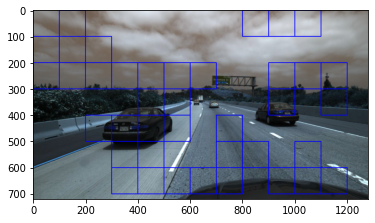

In [154]:
img_dir = './data/test/clips/3/imgs/040.jpg'
img = cv2.imread(img_dir)
dist_pickle = pickle.load(open("model", "rb"))

# img = cv2.resize(img, (320, 180))
# test_img = img[0:320, 0:180]
# plt.imshow(test_img)
# plt.show()
# test_img = cv2.resize(test_img, (320, 180))
# features = extract_features(test_img).reshape(1, -1)
# res = dist_pickle.predict(features)
# print(res)


on_windows = search_window(img, dist_pickle, xy_window=(100, 100), xy_overlap=(0, 0))
for window in on_windows:
    cv2.rectangle(img, (window[0][0], window[0][1]), (window[1][0], window[1][1]), (0,0,255), 2)

# print(on_windows)
plt.imshow(img)
plt.show()